In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Importar pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import MinMaxScaler, StandardScaler


In [70]:
path = 'data/Consulta_inflacion_mes_anio.csv'
df = pd.read_csv(path, sep=',', encoding='utf-8')
columnas = df.columns  
df

,Date,Month_inflation,Annual_inflation
0,01/01/1970,0.76,5.20
1,02/01/1970,-0.01,4.81
2,03/01/1970,0.29,5.01
3,04/01/1970,0.13,4.87
4,05/01/1970,0.21,5.09
...,...,...,...
647,12/01/2023,0.71,4.66
648,01/01/2024,0.89,4.88
649,02/01/2024,0.09,4.40
650,03/01/2024,0.29,4.42


<Axes: xlabel='Date'>

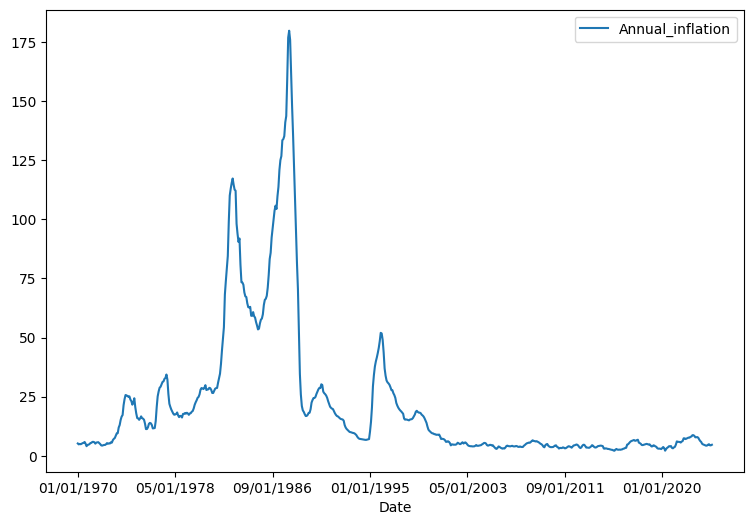

In [71]:
df.plot( x="Date", y="Annual_inflation", x_compat=True, figsize=(9,6) )


In [72]:
"""
Normalizamos los datos
"""

columns_to_normalize = ["Month_inflation", "Annual_inflation"]
scaler = MinMaxScaler()
df_normalized_minmax = df.copy()
df_normalized_minmax[columns_to_normalize] = scaler.fit_transform( df[columns_to_normalize])

"""
Los datos de entrenamiento serán de 1970-2010.
Del 2011 para arriba serán de validación
"""

split_index = df_normalized_minmax.index[df['Date'] == "01/01/2011"].item()
train_df = df_normalized_minmax.iloc[:split_index]
test_df = df_normalized_minmax.iloc[split_index:]

# print(split_index)
# print(train_df)
# print(test_df)


In [73]:
x_train = train_df["Month_inflation"].values.astype(np.float32)
y_train = train_df["Annual_inflation"].values.astype(np.float32)

x_train_tensor = torch.tensor(x_train)
y_train_tensor = torch.tensor(y_train)

dataset = TensorDataset(x_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

In [74]:
#Crear el modelo
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = ( torch.zeros(1,1,self.hidden_layer_size),
                             torch.zeros(1,1,self.hidden_layer_size) )
        
        self.historial_error = []

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [87]:
def entrena_modelo(modelo, dataloader, epochs, loss_function, optimizer):
    for i in range(epochs):
        for batch_x, batch_y in dataloader:
            optimizer.zero_grad()
            modelo.hidden_cell = (torch.zeros(1, 1, modelo.hidden_layer_size),
                            torch.zeros(1, 1, modelo.hidden_layer_size))

            y_pred = modelo(batch_x)

            single_loss = loss_function(y_pred, batch_y)
            single_loss.backward()
            optimizer.step()

        if i%25 == 1:
            print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
            modelo.historial_error.append( single_loss.item() )

In [88]:
def print_error_plot(historial):
    #plt.figure()
    plt.plot(historial)
    plt.title("Progreso del error")
    plt.xlabel("Iteración")
    plt.ylabel("Error")
    plt.show()

In [89]:
    
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Entrenar el modelo
epochs = 150

entrena_modelo(model, dataloader, epochs, loss_function, optimizer)

epoch:   1 loss: 0.00242026
epoch:  26 loss: 0.05258107
epoch:  51 loss: 0.00331817
epoch:  76 loss: 0.00772153
epoch: 101 loss: 0.03123732
epoch: 126 loss: 0.00496002


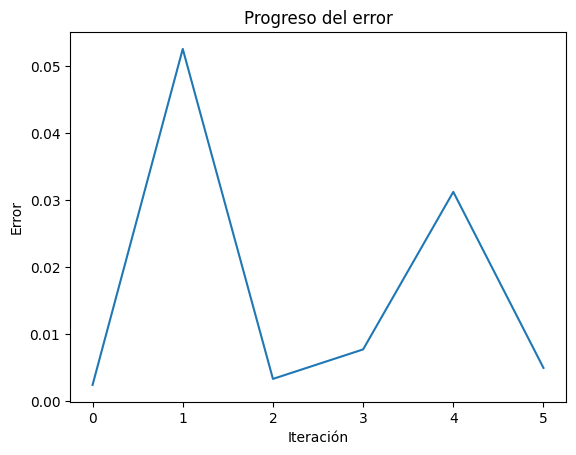

In [90]:
print_error_plot(model.historial_error)